In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import math
import pylab
import scipy.stats as stats
%matplotlib inline

In [2]:
# function to make buckets based on maximum price
def makeBuckets(maxNum):
    bucketDict = {}   
    start = 0

    while start < maxNum :
        # make a starting range first
        if start == 0 :
            end = 50
        else :
            factor = 1.2
            if start > 300 :
                factor = 1.1
            end = int(start*factor)
        strRange = str(start) + "-" + str(end)
        numRange = []
        numRange.append(start)
        numRange.append(end)
        bucketDict[strRange] = numRange
        
        start = end
    # for unseen data add extra bucket
    strRange = str(start) + "-inf"
    numRange = []
    numRange.append(start)
    numRange.append(2**32)
    bucketDict[strRange] = numRange
    
    return bucketDict

In [3]:
# function to convert continuous price into buckets; takes dictionary that came from makeBuckets()
def convert_price_buckets(val, bucketDict):
    for strRange in bucketDict:
        interval = bucketDict[strRange]
        if val >= interval[0] and val < interval[1]:
            return strRange
    # if unseen/incorrect data return open ended interval
    return "0-inf"

In [4]:
data = pd.read_csv('./SF/listings.csv', low_memory=False)
print ('Number of records:', len(data))

Number of records: 8111


In [5]:
data.columns # 'latitude','longitude'

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

In [71]:

badCols = ['listing_url', 'scrape_id', 'last_scraped','interaction','house_rules','thumbnail_url','medium_url',
 'picture_url','xl_picture_url','host_id','host_url','host_name','host_location','host_about','host_response_time',
 'host_response_rate','host_acceptance_rate','host_thumbnail_url','host_picture_url','host_neighbourhood',
           'host_listings_count','host_total_listings_count','host_verifications','city','state','market',
 'smart_location','country_code','country','latitude','longitude','is_location_exact','minimum_nights',
 'maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
 'minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated','has_availability','availability_30',
 'availability_60','availability_90','availability_365','calendar_last_scraped','requires_license','license',
 'jurisdiction_names','instant_bookable','is_business_travel_ready','cancellation_policy',
           'require_guest_profile_picture','require_guest_phone_verification','calculated_host_listings_count',
           'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms','reviews_per_month', 'transit', 'access', 'notes', 'first_review', 
           'last_review', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview',
          'extra_people', 'number_of_reviews_ltm', 'review_scores_accuracy', 'review_scores_cleanliness',
          'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
          'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'amenities', 
           'square_feet', 'weekly_price', 'monthly_price']

dataCopy = data.drop(badCols, axis=1)
dataCopy['price'] = (dataCopy['price'].str.replace(r'[^-+\d.]', '').astype(float)).astype(int)

dataCopy['security_deposit'] = (dataCopy['security_deposit'].str.replace(r'[^-+\d.]', '').astype(float))
dataCopy['security_deposit'].fillna(0, inplace=True)
dataCopy['security_deposit'] = dataCopy['security_deposit'].astype(int)

dataCopy['cleaning_fee'] = (dataCopy['cleaning_fee'].str.replace(r'[^-+\d.]', '').astype(float))
dataCopy['cleaning_fee'].fillna(0, inplace=True)
dataCopy['cleaning_fee'] = dataCopy['cleaning_fee'].astype(int)

print ('Number of records:', len(dataCopy))

for col in dataCopy.columns:
    print (col + ', Number of Missing Values:', len(dataCopy[col][dataCopy[col].isnull()]) )



Number of records: 8111
id, Number of Missing Values: 0
host_since, Number of Missing Values: 8
host_is_superhost, Number of Missing Values: 8
host_has_profile_pic, Number of Missing Values: 8
host_identity_verified, Number of Missing Values: 8
zipcode, Number of Missing Values: 245
property_type, Number of Missing Values: 0
room_type, Number of Missing Values: 0
accommodates, Number of Missing Values: 0
bathrooms, Number of Missing Values: 12
bedrooms, Number of Missing Values: 4
beds, Number of Missing Values: 9
bed_type, Number of Missing Values: 0
price, Number of Missing Values: 0
security_deposit, Number of Missing Values: 0
cleaning_fee, Number of Missing Values: 0
guests_included, Number of Missing Values: 0
number_of_reviews, Number of Missing Values: 0
review_scores_rating, Number of Missing Values: 1651


In [72]:
# if you want to put prices in the buckets

# maxPrice = data['price'].max()
# buckets = makeBuckets(maxPrice)
# data['price'] = data['price'].apply(convert_price_buckets, args=(buckets,))

In [73]:
# remove NaN values from dataframe
original = len(dataCopy)
dataCopy = dataCopy.dropna(how='any', subset=['zipcode', 'bathrooms'])
print ('Number of NaN values removed:', original - len(dataCopy) )

Number of NaN values removed: 257


In [74]:
# for bedrooms and beds replace it with 0
dataCopy['bedrooms'].fillna(0, inplace=True)
dataCopy['beds'].fillna(0, inplace=True)

In [75]:
for col in dataCopy.columns:
    print (col + ', Number of Missing Values:', len(dataCopy[col][dataCopy[col].isnull()]) )

id, Number of Missing Values: 0
host_since, Number of Missing Values: 8
host_is_superhost, Number of Missing Values: 8
host_has_profile_pic, Number of Missing Values: 8
host_identity_verified, Number of Missing Values: 8
zipcode, Number of Missing Values: 0
property_type, Number of Missing Values: 0
room_type, Number of Missing Values: 0
accommodates, Number of Missing Values: 0
bathrooms, Number of Missing Values: 0
bedrooms, Number of Missing Values: 0
beds, Number of Missing Values: 0
bed_type, Number of Missing Values: 0
price, Number of Missing Values: 0
security_deposit, Number of Missing Values: 0
cleaning_fee, Number of Missing Values: 0
guests_included, Number of Missing Values: 0
number_of_reviews, Number of Missing Values: 0
review_scores_rating, Number of Missing Values: 1529


In [76]:
# make sure important fields are none zero (drop them if it is)
dataCopy = dataCopy[dataCopy['accommodates'] != 0]
dataCopy = dataCopy[dataCopy['price'] != 0.00]

In [77]:
# convert ZipCode
dataCopy['zipcode'] = dataCopy['zipcode'].str.replace(r'-\d+', '')

In [78]:
# explore distribution of accommodates
print ('Number of Unique Accomodation: ', np.unique(dataCopy['accommodates']))
for i in range(1, 23):
    print ('Accommodation {}:'.format(i), len(dataCopy[dataCopy['accommodates'] == i]))

Number of Unique Accomodation:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Accommodation 1: 763
Accommodation 2: 3522
Accommodation 3: 666
Accommodation 4: 1540
Accommodation 5: 353
Accommodation 6: 617
Accommodation 7: 103
Accommodation 8: 174
Accommodation 9: 21
Accommodation 10: 44
Accommodation 11: 11
Accommodation 12: 23
Accommodation 13: 1
Accommodation 14: 6
Accommodation 15: 6
Accommodation 16: 3
Accommodation 17: 0
Accommodation 18: 0
Accommodation 19: 0
Accommodation 20: 0
Accommodation 21: 0
Accommodation 22: 0


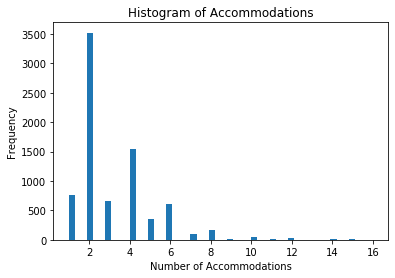

In [79]:
# visualize distribution of price (target variable)
plt.hist(dataCopy['accommodates'], bins=50)
plt.title("Histogram of Accommodations")
plt.xlabel("Number of Accommodations")
plt.ylabel("Frequency")
plt.show()

Number of Unique Beds:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 12. 14.]


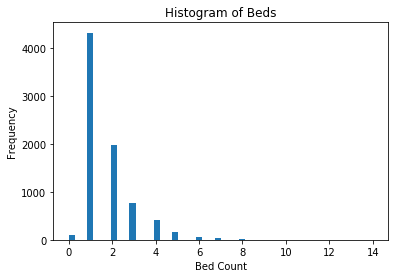

In [80]:
print ('Number of Unique Beds: ', np.unique(dataCopy['beds']))
# visualize distribution of beds
plt.hist(dataCopy['beds'], bins=50)
plt.title("Histogram of Beds")
plt.xlabel("Bed Count")
plt.ylabel("Frequency")
plt.show()

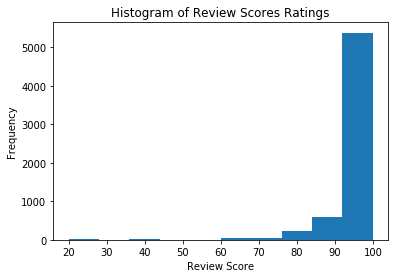

In [81]:
# visualize distribution of review scores ratings
plt.hist(dataCopy['review_scores_rating'][~dataCopy['review_scores_rating'].isnull()])
plt.title("Histogram of Review Scores Ratings")
plt.xlabel("Review Score")
plt.ylabel("Frequency")
plt.show()


In [82]:
# turn NaN scores with 0 reviews into 'No Reviews'
idx_vals = dataCopy['review_scores_rating'][dataCopy['number_of_reviews'] == 0].index.values.tolist()
dataCopy.loc[idx_vals, ('review_scores_rating')] = dataCopy['review_scores_rating'][dataCopy['number_of_reviews'] == 0].replace('NaN', 'No Reviews')

# remove inconsistent NaN values
dataCopy = dataCopy[~dataCopy['review_scores_rating'].isnull()]

In [83]:
# ensure all zipcodes are of length 5
dataCopy = dataCopy[dataCopy['zipcode'].map(len) == 5]


In [84]:
def dateToTimeframe(startTime) :
    if pd.isnull(startTime):
        return np.datetime64('NaT')
    startTime = np.datetime64(startTime)
    current = np.datetime64('today')
    diff = current.astype('datetime64[Y]') - startTime.astype('datetime64[Y]')
    return diff


# change objects to dates in "host_since"
dataCopy['host_since']= pd.to_datetime(dataCopy['host_since']) 

dataCopy['host_since'] = dataCopy['host_since'].apply(dateToTimeframe)

data = dataCopy
data.head()

# TODO: think what's the best way to handle empty values in "host_since": drop or fill with avg/means ?

,id,host_since,host_is_superhost,host_has_profile_pic,host_identity_verified,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,number_of_reviews,review_scores_rating
0,958,11 years,t,t,t,94117,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,170,100,100,2,217,97.0
1,3850,11 years,t,t,t,94131,House,Private room,2,1.0,1.0,1.0,Real Bed,99,0,10,2,160,94.0
2,5858,10 years,f,t,t,94110,Apartment,Entire home/apt,5,1.0,2.0,3.0,Real Bed,235,0,100,2,111,98.0
3,7918,10 years,t,t,t,94117,Apartment,Private room,2,4.0,1.0,1.0,Real Bed,65,200,50,1,18,86.0
4,8142,10 years,t,t,t,94117,Apartment,Private room,2,4.0,1.0,1.0,Real Bed,65,200,50,1,8,93.0


In [85]:
# convert review_scores_rating into buckets
def convert_scores_buckets(val):
    if val == 'No Reviews':
        return 'No Reviews'
    elif val >= 95.0:
        return '95-100'
    elif val >= 90.0 and val < 95.0:
        return '90-94'
    elif val >= 85.0 and val < 90.0:
        return '85-89'
    elif val >= 80.0 and val < 85.0:
        return '80-84'
    elif val >= 70.0 and val < 80.0:
        return '70-79'
    elif val >= 60.0 and val < 70.0:
        return '60-69'
    elif val >= 50.0 and val < 60.0:
        return '50-59'
    elif val >= 40.0 and val < 50.0:
        return '40-49'
    elif val >= 30.0 and val < 40.0:
        return '30-39'
    elif val >= 20.0 and val < 30.0:
        return '20-29'
    elif val >= 10.0 and val < 20.0:
        return '10-19'
    elif val < 10.0:
        return '0-9'

data['review_scores_rating'] = data['review_scores_rating'].apply(convert_scores_buckets)
print ('Unique Values in the Column:', np.unique(data['review_scores_rating']))

Unique Values in the Column: ['20-29' '30-39' '40-49' '50-59' '60-69' '70-79' '80-84' '85-89' '90-94'
 '95-100']


In [87]:
print ('Number of remaining records:', len(data))

data.to_csv('./SF/general_data_clean.csv', index=False)

Number of remaining records: 6311


In [22]:
# encode categorical variables
zipcode_dummies = pd.get_dummies(data['zipcode'])
property_dummies = pd.get_dummies(data['property_type'])
room_dummies = pd.get_dummies(data['room_type'])
bed_dummies = pd.get_dummies(data['bed_type'])
ratings_scores_dummies = pd.get_dummies(data['review_scores_rating'])

# replace the old columns with our new one-hot encoded ones
data = pd.concat((data.drop(['zipcode', \
    'property_type', 'room_type', 'bed_type', 'review_scores_rating'], axis=1), \
    zipcode_dummies.astype(int), property_dummies.astype(int), \
    room_dummies.astype(int), bed_dummies.astype(int), ratings_scores_dummies.astype(int)), \
    axis=1)

print ('Number of Columns:', len(data.columns))

Number of Columns: 251


In [23]:
# ?????   IF NEEDED   ??????
# likely useful to make non-uniformly distributed features uniform: that helps linearity (as I understood)
# convert non-categorical variables to floats and standardize
def standardize_col(col):
    mean = np.mean(col)
    std = np.std(col)
    return col.apply(lambda x: (x - mean) / std)

non_cat_vars = ['accommodates', 'bedrooms', 'beds', 'number_of_reviews', 'bathrooms']
dataStndrd = data
for col in non_cat_vars:
    dataStndrd[col] = dataStndrd[col].astype(float)
    dataStndrd[col] = standardize_col(dataStndrd[col])

dataStndrd.head(20)

,id,host_since,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,...,20-29,30-39,40-49,50-59,60-69,70-79,80-84,85-89,90-94,95-100
1,3831,11 years,f,t,t,0.048703,-0.330840,-0.241378,2.109095,89,...,0,0,0,0,0,0,0,0,1,0
2,5022,10 years,f,t,t,-1.004650,-0.330840,-1.582986,-0.500705,80,...,0,0,0,0,0,0,0,0,1,0
3,5099,10 years,f,t,f,-0.477974,-0.330840,-0.241378,-0.500705,200,...,0,0,0,0,0,0,0,1,0,0
5,5178,10 years,f,t,f,-0.477974,-0.330840,-0.241378,-0.500705,79,...,0,0,0,0,0,0,1,0,0,0
6,5203,10 years,f,t,t,-1.004650,-0.330840,-0.241378,-0.500705,79,...,0,0,0,0,0,0,0,0,0,1
7,5222,10 years,f,t,t,-0.477974,-0.330840,-0.241378,-0.500705,116,...,0,0,0,0,0,0,0,0,0,1
8,5238,10 years,t,t,t,0.048703,-0.330840,-0.241378,0.369228,150,...,0,0,0,0,0,0,0,0,1,0
9,5295,10 years,f,t,t,-0.477974,-0.330840,-0.241378,-0.500705,135,...,0,0,0,0,0,0,0,0,1,0
10,5441,10 years,t,t,t,-0.477974,-0.330840,-0.241378,-0.500705,85,...,0,0,0,0,0,0,0,0,0,1
11,5803,10 years,t,t,t,-0.477974,-0.330840,-0.241378,-1.370638,89,...,0,0,0,0,0,0,0,0,1,0


In [24]:
# dataStndrd.to_csv('general_data_clean.csv', index=False)

In [46]:
len(badCols)

87